In [159]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ModuleNotFoundError: No module named 'geopandas'

In [4]:
df = pd.read_csv(r'boston_corrected.csv')

## Checking and cleaning the data

This data frame contains the following columns:

* TOWN a factor with levels given by town names
    * Should all be strings
    * All have capital letter at the beginning of each word

* TOWNNO a numeric vector corresponding to TOWN
    * Should be int
    * Should be same number as number of unique town names

* TRACT a numeric vector of tract ID numbers
    * Should be int
    * Should be >= 0

* LON a numeric vector of tract point longitudes in decimal degrees
    * Should be float
    * Should be between -180 and 180

* LAT a numeric vector of tract point latitudes in decimal degrees
    * Should be float
    * Should be between -90 and 90

* MEDV a numeric vector of median values of owner-occupied housing in USD 1000
    * Should be float

* CMEDV a numeric vector of corrected median values of owner-occupied housing in USD 1000
    * Should be float

* CRIM a numeric vector of per capita crime
    * Should be float

* ZN a numeric vector of proportions of residential land zoned for lots over 25000 sq. ft per town (constant for all Boston tracts)
    * Should be float

* INDUS a numeric vector of proportions of non-retail business acres per town (constant for all Boston tracts)
    * Should be float

* CHAS a factor with levels 1 if tract borders Charles River; 0 otherwise
    * Should be int

* NOX a numeric vector of nitric oxides concentration (parts per 10 million) per town
    * Should be float

* RM a numeric vector of average numbers of rooms per dwelling
    * Should be float

* AGE a numeric vector of proportions of owner-occupied units built prior to 1940
    * Should be float

* DIS a numeric vector of weighted distances to five Boston employment centres
    * Should be float

* RAD a numeric vector of an index of accessibility to radial highways per town (constant for all Boston tracts)
    * Should be float

* TAX a numeric vector full-value property-tax rate per USD 10,000 per town (constant for all Boston tracts)
    * Should be float

* PTRATIO a numeric vector of pupil-teacher ratios per town (constant for all Boston tracts)
    * Should be float

* B a numeric vector of 1000*(Bk - 0.63)^2 where Bk is the proportion of blacks
    * Should be float

* LSTAT a numeric vector of percentage values of lower status population
    * Should be float

Adapted from: https://nowosad.github.io/spData/reference/boston.html

In [5]:
df.head()

,TOWN,TOWNNO,TRACT,LON,LAT,MEDV,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,Nahant,0,2011,-70.955,42.2550,24.0,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,Swampscott,1,2021,-70.950,42.2875,21.6,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,Swampscott,1,2022,-70.936,42.2830,34.7,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,Marblehead,2,2031,-70.928,42.2930,33.4,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,Marblehead,2,2032,-70.922,42.2980,36.2,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


### Checking that there are no null values and that dtypes are as expected

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TOWN     506 non-null    object 
 1   TOWNNO   506 non-null    int64  
 2   TRACT    506 non-null    int64  
 3   LON      506 non-null    float64
 4   LAT      506 non-null    float64
 5   MEDV     506 non-null    float64
 6   CMEDV    506 non-null    float64
 7   CRIM     506 non-null    float64
 8   ZN       506 non-null    float64
 9   INDUS    506 non-null    float64
 10  CHAS     506 non-null    int64  
 11  NOX      506 non-null    float64
 12  RM       506 non-null    float64
 13  AGE      506 non-null    float64
 14  DIS      506 non-null    float64
 15  RAD      506 non-null    int64  
 16  TAX      506 non-null    int64  
 17  PTRATIO  506 non-null    float64
 18  B        506 non-null    float64
 19  LSTAT    506 non-null    float64
dtypes: float64(14), int64(5), object(1)
memory usage: 79.2

In [19]:
sorted(df.TOWN.unique())

['Arlington',
 'Ashland',
 'Bedford',
 'Belmont',
 'Beverly',
 'Boston Allston-Brighton',
 'Boston Back Bay',
 'Boston Beacon Hill',
 'Boston Charlestown',
 'Boston Dorchester',
 'Boston Downtown',
 'Boston East Boston',
 'Boston Forest Hills',
 'Boston Hyde Park',
 'Boston Mattapan',
 'Boston North End',
 'Boston Roxbury',
 'Boston Savin Hill',
 'Boston South Boston',
 'Boston West Roxbury',
 'Braintree',
 'Brookline',
 'Burlington',
 'Cambridge',
 'Canton',
 'Chelsea',
 'Cohasset',
 'Concord',
 'Danvers',
 'Dedham',
 'Dover',
 'Duxbury',
 'Everett',
 'Framingham',
 'Hamilton',
 'Hanover',
 'Hingham',
 'Holbrook',
 'Hull',
 'Lexington',
 'Lincoln',
 'Lynn',
 'Lynnfield',
 'Malden',
 'Manchester',
 'Marblehead',
 'Marshfield',
 'Medfield',
 'Medford',
 'Melrose',
 'Middleton',
 'Millis',
 'Milton',
 'Nahant',
 'Natick',
 'Needham',
 'Newton',
 'Norfolk',
 'North Reading',
 'Norwell',
 'Norwood',
 'Peabody',
 'Pembroke',
 'Quincy',
 'Randolph',
 'Reading',
 'Revere',
 'Rockland',
 'Sale

### Check that the characteristics of each column are as expected as defined above

In [30]:
assert len(df.TOWN.unique()) == len(df.TOWNNO.unique()), 'Number of unique town names must be equal to number of unique town numbers'

In [31]:
assert all(df.TRACT) >= 0, 'ID numbers must be greater than or equal to zero'

In [32]:
assert -180 <= all(df.LON) <= 180, 'Longitude must be between -180 and 180'

In [33]:
assert -90 <= all(df.LAT) <= 90, 'Latitude must be between -90 and 90'

In [ ]:
# FINISH ASSERTIONS

### Dropping the MEDV column as CMEDV will be used as our target variable and we do not want data leakage

In [41]:
df.drop('MEDV', axis=1, inplace=True)

### Dropping TOWN because it repeats information in TOWNNO

In [46]:
df.drop('TOWN', axis=1, inplace=True)

### Seperate explanatory variables from target and split into train and test set (80:20), will be using cross-validation on training set

In [48]:
X = df.copy()
y = X.pop('CMEDV')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

### Normalizing data using StandardScaler()

In [71]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
X_train_sc = x_scaler.fit_transform(X_train)
X_test_sc = x_scaler.transform(X_test)

## Feature engineering

### Calculate a mutual information score to understand how knowledge of one quantity reduces uncertainty about the target variable

* 0 means that the quantities are independent
* The higher the score the better
* Scores > 2 are uncommon as mutual information score increases slowly as it is a logarithmic quantity

In [72]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X, y, random_state=2021)
mi_scores_series = pd.Series(mi_scores, name="MI Scores", index=X.columns).sort_values(ascending=False)

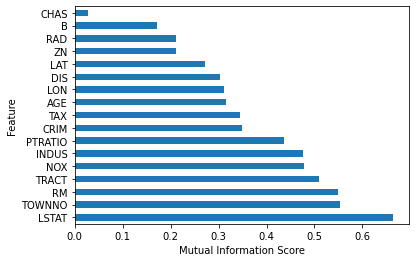

In [73]:
mi_scores_series.plot.barh()
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.show()

### Principle Component Analysis

In [104]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_sc)

component_names = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=component_names)

X_train_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
0,-0.474877,-2.359316,-0.747259,0.300352,0.798316,-0.463199,0.874487,0.088129,0.168444,-0.913139,-0.051822,0.003383,-0.610677,-0.173151,0.143654,-0.084135,0.349282
1,0.627174,-0.378406,-0.491084,-0.515009,0.686680,-0.385052,-0.142420,0.283021,-0.283885,0.558356,-0.452342,0.551116,1.218101,-0.031665,0.619261,0.714758,0.106637
2,-4.254421,3.132518,-0.190962,0.144054,-1.198739,0.688558,-0.733744,0.527282,-0.492625,-0.863658,0.349046,0.082923,0.199815,-0.310842,0.183297,-0.332851,0.522589
3,6.177900,0.552626,-1.452193,0.645156,-2.860588,1.970371,0.490201,-0.239288,2.430967,-0.195271,-0.069706,0.023369,0.317522,-0.003930,-0.000908,0.099728,-0.039584
4,0.813223,-2.337475,0.781455,-1.113474,-0.921345,0.041664,-0.444227,-0.315023,0.004186,-1.181147,1.108294,-0.576703,0.745810,0.106962,0.739943,-0.669695,-0.404329


In [128]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X_train.columns,  # and the rows are the original features
)
loadings = pd.concat([loadings, pd.DataFrame(X_train.columns, columns=['col_names'], index=X_train.columns)], axis=1)

In [129]:
loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,col_names
TOWNNO,0.232274,0.466451,-0.095313,-0.224702,0.121889,-0.070635,-0.042013,0.084491,-0.055900,0.096926,-0.121036,0.132155,0.469270,0.186079,0.277470,0.453218,-0.241404,TOWNNO
TRACT,-0.302635,0.012630,0.172276,-0.394181,-0.208150,-0.052754,0.037343,-0.084720,0.193372,-0.087324,0.225976,-0.016560,0.000434,0.020963,-0.524327,0.199555,-0.506927,TRACT
LON,0.070555,-0.293310,-0.392224,-0.304165,0.223722,0.088867,0.618653,0.364948,-0.090101,0.138346,0.077684,-0.047726,0.134007,0.065951,-0.118461,-0.129424,-0.010329,LON
LAT,-0.031868,-0.528952,-0.022053,0.603732,0.028445,0.041527,-0.044555,0.050974,-0.118501,0.087292,0.017796,0.034387,0.223936,0.105301,-0.049518,0.370440,-0.350747,LAT
CRIM,0.233420,0.154422,-0.124231,0.261569,-0.183630,0.133448,0.067693,0.289449,0.780442,0.094662,0.262315,0.005180,-0.074498,0.006236,0.031963,0.061104,0.026361,CRIM


<BarContainer object of 17 artists>

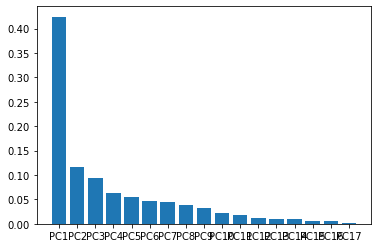

In [115]:
plt.bar(component_names, pca.explained_variance_ratio_)

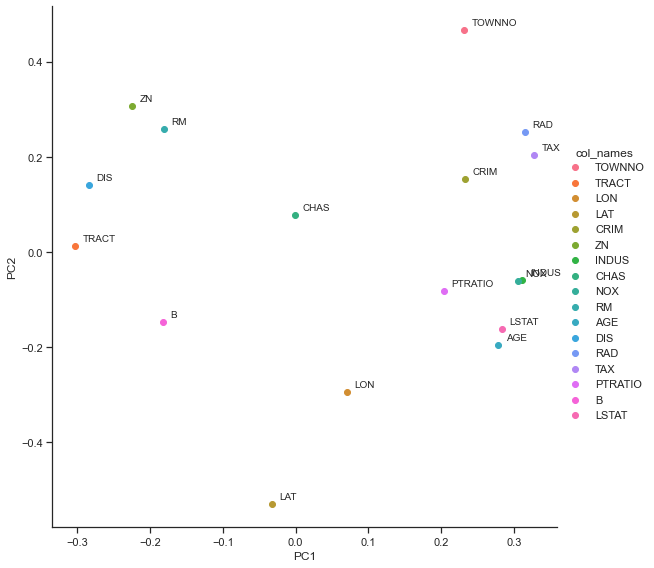

In [165]:
%matplotlib inline

fg = sns.FacetGrid(data=loadings, hue='col_names', hue_order=X_train.columns, height=8)
fg.map(plt.scatter, 'PC1', 'PC2').add_legend(ncol=1)
for x, y, label in zip(loadings.PC1, loadings.PC2, loadings.col_names):
    plt.text(x=x+0.01, y=y+0.01, s=label)

### Benchmark model: Linear Regression

In [87]:
def mean_absolute_percentage_error(true, predicted):
    return np.mean(abs((true-predicted)/true))*100

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

benchmark_model = LinearRegression(n_jobs=-1)
benchmark_model.fit(X_train_sc, y_train)
train_pred = benchmark_model.predict(X_train_sc)
train_RMSE = mean_squared_error(y_train, train_pred, squared=False)
train_MAPE = mean_absolute_percentage_error(y_train, train_pred)
test_pred = benchmark_model.predict(X_test_sc)
test_RMSE = mean_squared_error(y_test, test_pred, squared=False)
test_MAPE = mean_absolute_percentage_error(y_test, test_pred)

In [94]:
benchmark_res = {'train_RMSE':[train_RMSE], 'test_RMSE':[test_RMSE], 'train_MAPE':[train_MAPE], 'test_MAPE':[test_MAPE]}
evaluation = pd.DataFrame(benchmark_res, index=['benchmark'])

In [95]:
evaluation

,train_RMSE,test_RMSE,train_MAPE,test_MAPE
benchmark,4.564629,4.976568,16.783678,18.028588
